In [1]:
import pandas as pd
import numpy as np

import requests
import json

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
class HierroCaller(object):
    
    """
    This is an API caller for the El Hierro power data streams.
    
    * The caller is initialised with a start and end date including and between which the calls will be made for
    * The call is made using .MakeCall() which will return a dataframe containing the power timeseries
    
    """
    
    
    ## ~~~~~~~~~~~~ Core Functions ~~~~~~~~~~~~
        
    def date_2_raw_df(self, date):
        ## Forming the url
        url = f'https://demanda.ree.es/WSvisionaMovilesCanariasRest/resources/demandaGeneracionCanarias?curva=EL_HIERRO&fecha={date}'

        ## Making the request and parsing it to JSON
        response = requests.get(url)
        hierro_json = json.loads(response.text[5:-2])

        ## Converting the JSON to a dataframe
        df_hierro_raw = pd.DataFrame(hierro_json['valoresHorariosGeneracion'])
        
        return df_hierro_raw
        
    def clean_raw_df(self, df_hierro_day_raw):
        ## El Hierro only has diesel, wind and hydro so unnecessary columns are dropped, with the remaining renamed.
        ## The datetime column is parsed into a Pandas Timestamp series and set as the index
        
        df_hierro_day_clean = (df_hierro_day_raw.copy()
                               .drop(columns=['cc', 'ele', 'fot', 'gas', 'vap']) 
                               .rename(columns={'dem':'demand', 'die':'diesel', 'eol':'wind', 'hid':'hydro', 'ts':'datetime'})
                               .assign(datetime=pd.to_datetime(df_hierro_day_raw.ts.str.replace('A', '0')))
                               .set_index('datetime')
                              )
        
        return df_hierro_day_clean
    
    def select_relevant_datetimes(self, df_hierro_day_clean, date):
            ## Day component of the date is selected and converted to an integer
            day = int(date[-2:])

            ## The head and tail values outside the selected day are removed
            df_hierro = df_hierro_day_clean[df_hierro_day_clean.index.day==day] 

            return df_hierro
        
    def date_list_2_df(self, date_list):
        df_hierro = pd.DataFrame()

        for date in date_list:
            df_hierro_day_raw = self.date_2_raw_df(date)
            df_hierro_day_clean = self.clean_raw_df(df_hierro_day_raw)
            df_hierro_day_relevant = self.select_relevant_datetimes(df_hierro_day_clean, date)
            df_hierro = df_hierro.append(df_hierro_day_relevant)

        return df_hierro
    
    def MakeCall(self):
        date_list = (pd.date_range(self.start_date, self.end_date) # Creating a DatetimeIndex of the dates
                     .astype(str) # Converting the DatetimeIndex to a series of strings
                    )
        df_hierro = self.date_list_2_df(date_list)
        
        return df_hierro
          
        
    ## ~~~~~~~~~~~~ Initializer & Helper Functions ~~~~~~~~~~~~
    
    def info(self):
        info_dict = {
            'start_date' : self.start_date,
            'end_date' : self.end_date
        }
        
        return info_dict
    
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date

In [3]:
start_date = '2016-01-01'
end_date = '2016-03-31'

make_call = False
if make_call == True:
    hierro_caller = HierroCaller(start_date, end_date)
    df_hierro_raw = hierro_caller.MakeCall()
    df_hierro_raw.to_csv('data/Jan_Mar_16.csv')
    df_hierro_raw.head(10)

In [4]:
month_ranges = ['Jan_Mar', 'Apr_Jun', 'Jul_Sep', 'Oct_Dec']
years = [16, 17, 18]

df_hierro = pd.DataFrame()

for year in years:
    for month_range in month_ranges:
        df_single_month_range = pd.read_csv(f'data/{month_range}_{year}.csv')
        df_hierro = (df_hierro
                     .append(df_single_month_range)
                     .reset_index(drop=True)
                    )
        
df_hierro = (df_hierro.copy()
             .assign(datetime=pd.to_datetime(df_hierro.datetime))
            )
df_hierro.head(10)

,datetime,demand,diesel,wind,hydro
0,2016-01-01 00:00:00,5.1,5.2,0.0,0.0
1,2016-01-01 00:10:00,5.1,5.2,0.0,0.0
2,2016-01-01 00:20:00,5.3,5.4,0.0,0.0
3,2016-01-01 00:30:00,5.3,5.4,0.0,0.0
4,2016-01-01 00:40:00,5.3,5.4,0.0,0.0
5,2016-01-01 00:50:00,5.3,5.4,0.0,0.0
6,2016-01-01 01:00:00,5.3,5.4,0.0,0.0
7,2016-01-01 01:10:00,5.0,5.1,0.0,0.0
8,2016-01-01 01:20:00,5.2,5.3,0.0,0.0
9,2016-01-01 01:30:00,5.1,5.2,0.0,0.0


In [5]:
df_hierro.to_csv('data/el_hierro_16_18.csv', index=False)

In [163]:
s_dts_all = pd.DatetimeIndex(freq='10T', start='2016-01-01', end='2018-12-31')
s_dts_missing = (pd.Series(list(set(s_dts_all) - set(df_hierro.datetime)))
                 .sort_values()
                 .reset_index(drop=True)
                )

s_dts_missing.head(10)

0   2016-03-27 01:00:00
1   2016-03-27 01:10:00
2   2016-03-27 01:20:00
3   2016-03-27 01:30:00
4   2016-03-27 01:40:00
5   2016-03-27 01:50:00
6   2016-06-02 12:10:00
7   2016-06-02 13:10:00
8   2016-10-30 01:00:00
9   2016-10-30 01:10:00
dtype: datetime64[ns]

Text(0,0.5,'Number of Missing Dates a Month')

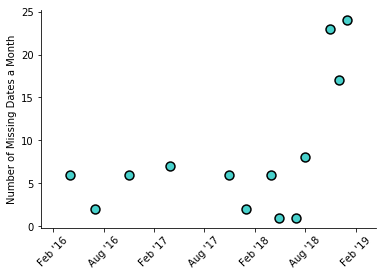

In [194]:
def plot_missing_dts_month_sum(s_dts_all_zeros_month_sum):
    fig = plt.figure()
    ax = plt.subplot()

    ax.scatter(s_dts_all_zeros_month_sum.index, s_dts_all_zeros_month_sum.values, facecolor='mediumturquoise', edgecolor='k', s=80, linewidths=1.5)
    sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))   #to get a tick every 15 minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y")) 
    plt.xticks(rotation=45)
    
s_dts_all_zeros = pd.Series(np.zeros(s_dts_all.shape[0]), index=s_dts_all)
s_dts_all_zeros[s_dts_missing] = 1

s_dts_all_zeros_month_sum = s_dts_all_zeros.resample('M').sum()
s_dts_all_zeros_month_sum = s_dts_all_zeros_month_sum[s_dts_all_zeros_month_sum>0]
    
plot_missing_dts_month_sum(s_dts_all_zeros_month_sum)
plt.ylabel('Number of Missing Dates a Month')

Text(0.5,0,'Group')

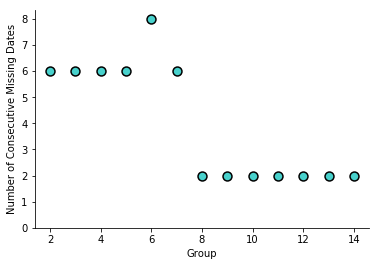

In [197]:
def s_trues_2_block_list(s):
    group_list = []

    for i in range(s.shape[0]):
        if i == 0:
            if s[i+1] == True:
                group_list.append(1)

        else:
            if a[i] == True:
                if s[i-1] == True:
                    group_list.append(max(group_list))
                elif i == 1:
                    group_list.append(max(group_list))
                else:
                    group_list[-1] = max(group_list)+1
                    group_list.append(max(group_list))
            else:
                group_list.append(0)
                
    return group_list

def quick_plot_s(s):
    fig = plt.figure()#dpi=1200)
    ax = plt.subplot()
    
    ax.scatter(s.index, s.values, facecolor='mediumturquoise', edgecolor='k', s=80, linewidths=1.5)
    
    sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
    ax.set_ylim(0)
                
df_missing_dts = (pd.DataFrame()
                  .assign(datetime=s_dts_missing)
                  .assign(datetime_shifted=s_dts_missing.shift(1))
                 )

bool_series = (df_missing_dts.datetime - df_missing_dts.datetime_shifted)==pd.Timedelta(minutes=10)

group_value_counts = (pd.Series(s_trues_2_block_list(bool_series))
                      .value_counts()
                      .sort_index()
                      [1:])

quick_plot_s(group_value_counts[1:])
plt.ylabel('Number of Consecutive Missing Dates')
plt.xlabel('Group')

In [310]:
def hydro_2_pump_and_dsch(df_hierro):
    df_hierro = (df_hierro.copy()
                 .assign(pump_hydro=df_hierro[df_hierro.hydro<0].hydro)
                 .assign(dsch_hydro=df_hierro[df_hierro.hydro>0].hydro)
                 .drop(columns='hydro')
                 .fillna(0)
                )
    return df_hierro

df_hierro_hydro_sep = hydro_2_pump_and_dsch(df_hierro)
df_hierro_hydro_sep.head(10)

,datetime,demand,diesel,wind,pump_hydro,dsch_hydro
0,2016-01-01 00:00:00,5.1,5.2,0.0,0.0,0.0
1,2016-01-01 00:10:00,5.1,5.2,0.0,0.0,0.0
2,2016-01-01 00:20:00,5.3,5.4,0.0,0.0,0.0
3,2016-01-01 00:30:00,5.3,5.4,0.0,0.0,0.0
4,2016-01-01 00:40:00,5.3,5.4,0.0,0.0,0.0
5,2016-01-01 00:50:00,5.3,5.4,0.0,0.0,0.0
6,2016-01-01 01:00:00,5.3,5.4,0.0,0.0,0.0
7,2016-01-01 01:10:00,5.0,5.1,0.0,0.0,0.0
8,2016-01-01 01:20:00,5.2,5.3,0.0,0.0,0.0
9,2016-01-01 01:30:00,5.1,5.2,0.0,0.0,0.0


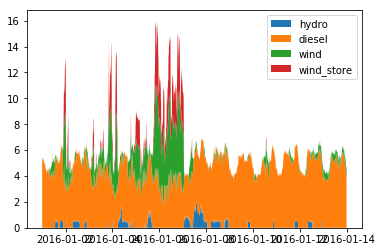

In [306]:
#week_plot = week_plot.assign(pump_hydro=week_plot[week_plot.hydro<0].hydro)
#week_plot = week_plot.assign(dsch_hydro=week_plot[week_plot.hydro>0].hydro)
#week_plot = week_plot.drop(columns='hydro')
#week_plot = week_plot.fillna(0)

plt.stackplot(week_plot.index, week_plot.dsch_hydro, week_plot.diesel, week_plot.wind, np.abs(week_plot.pump_hydro), labels=['hydro', 'diesel', 'wind', 'wind_store'])
plt.legend()

In [324]:
week_plot.sort_values('wind', ascending=False).head(10)

,demand,diesel,wind,hydro
datetime,,,,
2016-01-05 23:10:00,5.1,2.8,6.6,-4.2
2016-01-05 21:50:00,5.8,3.7,6.6,-4.5
2016-01-05 21:00:00,6.1,4.3,6.6,-4.7
2016-01-05 20:00:00,6.5,4.4,6.5,-4.4
2016-01-05 20:20:00,6.2,4.5,6.5,-4.7
2016-01-05 22:10:00,5.9,4.5,6.5,-4.9
2016-01-05 20:50:00,6.2,4.4,6.5,-4.5
2016-01-05 20:40:00,6.1,4.4,6.5,-4.7
2016-01-05 20:30:00,6.1,4.6,6.5,-4.9


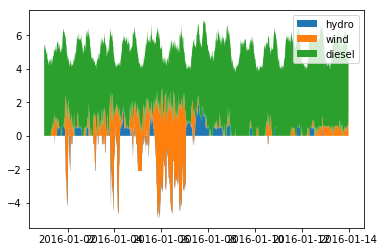

In [317]:
start_date = datetime(2016, 1, 1, 0, 0)
end_date = datetime(2016, 1, 14, 0, 0)
week_plot = df_hierro.set_index('datetime').loc[start_date:end_date]

plt.stackplot(week_plot.index, week_plot.hydro, week_plot.wind, week_plot.diesel, labels=['hydro', 'wind', 'diesel'])
plt.legend()

Text(0.5,0,'Wind')

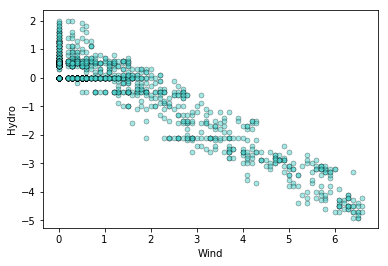

In [267]:
plt.scatter(week_plot.wind, week_plot.hydro, facecolor='mediumturquoise', edgecolor='k', s=25, linewidths=0.5, alpha=0.5)
plt.ylabel('Hydro')
plt.xlabel('Wind')

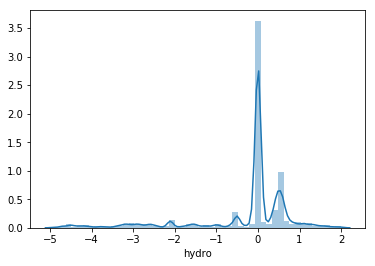

In [263]:
sns.distplot(week_plot.hydro)

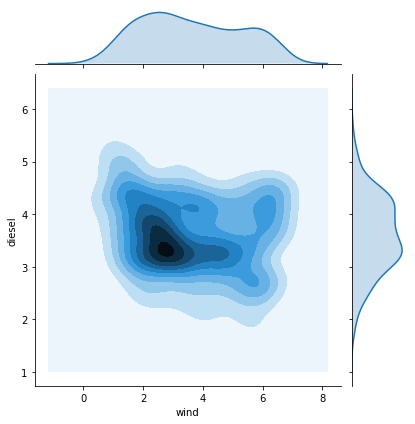

In [262]:
sns.jointplot(x="wind", y="diesel", data=week_plot[week_plot.hydro<0], kind="kde")

(0.0, 0.22534006213820784)

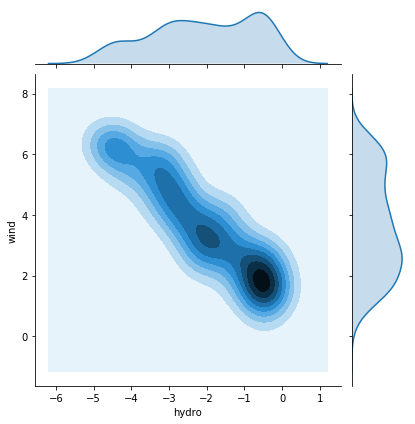

In [248]:
sns.jointplot(x="hydro", y="wind", data=week_plot[week_plot.hydro<0], kind="kde")
plt.xlim()

Text(0.5,0,'Change in Output')

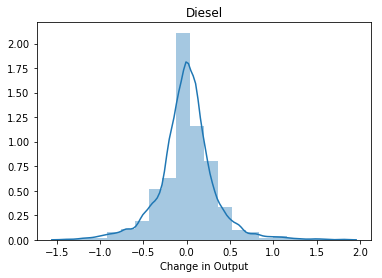

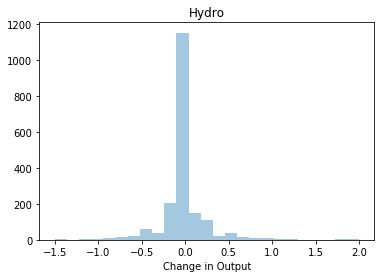

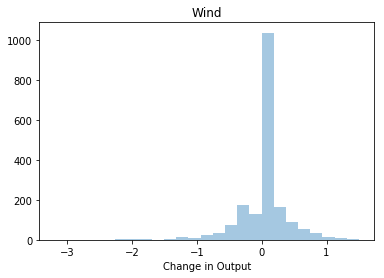

In [288]:
plt.figure()
sns.distplot((week_plot.diesel-week_plot.diesel.shift(1)).dropna(), bins=20)
plt.title('Diesel')
plt.xlabel('Change in Output')

plt.figure()
sns.distplot((week_plot.hydro-week_plot.hydro.shift(1)).dropna(), bins=25, kde=False)
plt.title('Hydro')
plt.xlabel('Change in Output')

plt.figure()
sns.distplot((week_plot.wind-week_plot.wind.shift(1)).dropna(), bins=25, kde=False)
plt.title('Wind')
plt.xlabel('Change in Output')
#plt.ylim(0, 4)

In [333]:
df_hierro_hydro_sep = df_hierro_hydro_sep.assign(pump_hydro_cumsum=df_hierro_hydro_sep.pump_hydro.cumsum())
df_hierro_hydro_sep = df_hierro_hydro_sep.assign(dsch_hydro_cumsum=df_hierro_hydro_sep.dsch_hydro.cumsum())
df_hierro_hydro_sep.head(10)

,datetime,demand,diesel,wind,pump_hydro,dsch_hydro,pump_hydro_cumsum,dsch_hydro_cumsum
0,2016-01-01 00:00:00,5.1,5.2,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 00:10:00,5.1,5.2,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 00:20:00,5.3,5.4,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 00:30:00,5.3,5.4,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 00:40:00,5.3,5.4,0.0,0.0,0.0,0.0,0.0
5,2016-01-01 00:50:00,5.3,5.4,0.0,0.0,0.0,0.0,0.0
6,2016-01-01 01:00:00,5.3,5.4,0.0,0.0,0.0,0.0,0.0
7,2016-01-01 01:10:00,5.0,5.1,0.0,0.0,0.0,0.0,0.0
8,2016-01-01 01:20:00,5.2,5.3,0.0,0.0,0.0,0.0,0.0
9,2016-01-01 01:30:00,5.1,5.2,0.0,0.0,0.0,0.0,0.0


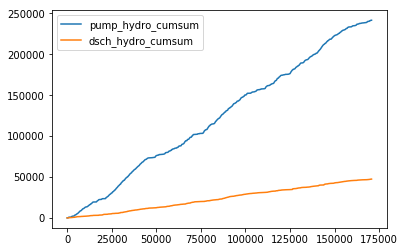

In [316]:
plt.plot(np.abs(df_hierro_hydro_sep.pump_hydro_cumsum))
plt.plot(df_hierro_hydro_sep.dsch_hydro_cumsum)
plt.legend()

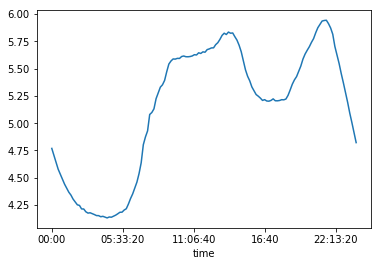

In [347]:
df_hierro_daily = (df_hierro_hydro_sep
                   .set_index('datetime')
                   .groupby(df_hierro_hydro_sep.set_index('datetime').index.time)
                   .demand
                   .mean()
                  )
df_hierro_daily.plot()